<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [84]:
# imports 


import numpy as np
import gensim
import os
import re

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

import pandas as pd

import glob
from pathlib import Path
import sys
import spacy

nlp = spacy.load('en_core_web_lg')

In [85]:
STOPWORDS = set(STOPWORDS).union(set(['said', 'mr', 'mrs']))

def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

def get_lemmas(text):
    doc = nlp(text)
    lemma_list = [token.lemma_ for token in doc if (token.is_stop != True) and (token.is_punct != True)]
    
    return lemma_list

In [86]:
path = '/home/zham/DS-Unit-4-Sprint-1-NLP/module1-text-data/data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv'

# loading the amazon data into a dataframe
df = pd.read_csv(path)

# selecting only the data we want and creating tokens
reviews = df[['reviews.text', 'reviews.text']]
reviews.columns = ['text', 'lemmas']
reviews['lemmas'] = reviews['lemmas'].apply(get_lemmas)

In [87]:
id2word = corpora.Dictionary(reviews['lemmas'])

# removing extreme values
id2word.filter_extremes(no_below=5, no_above=0.95)

In [90]:
corpus = [id2word.doc2bow(text) for text in reviews['lemmas']]

In [102]:
lda = LdaMulticore(corpus=corpus,
                    id2word=id2word,
                    random_state=723812,
                    num_topics = 15,
                    passes=10,
                    workers=4)

In [105]:
# top 5 words for each topic
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]
topics = [' '.join(t[0:5]) for t in words]
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
tablet great card memory storage

------ Topic 1 ------
old year love kindle buy

------ Topic 2 ------
app Amazon like store tablet

------ Topic 3 ------
gift need buy use Alexa

------ Topic 4 ------
device screen like button little

------ Topic 5 ------
good price quality great value

------ Topic 6 ------
get worth battery run power

------ Topic 7 ------
work great buy fine good

------ Topic 8 ------
charge light great iPad hold

------ Topic 9 ------
love game use buy easy

------ Topic 10 ------
product recommend great happy purchase

------ Topic 11 ------
battery great price deal life

------ Topic 12 ------
tablet kid great child love

------ Topic 13 ------
battery long brand buy last

------ Topic 14 ------
tablet Kindle book read Fire



In [93]:
# code from lecture to determine how many topics
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

In [97]:
coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus,
                                                        start=3, 
                                                        limit=20, 
                                                        step=2,
                                                        passes=10)

In [98]:
topic_coherence = pd.DataFrame.from_records(coherence_values)

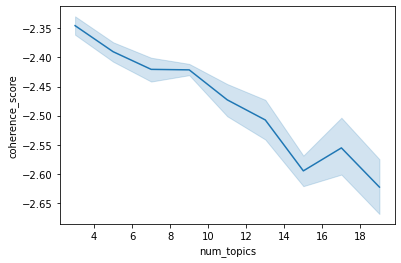

In [99]:
import seaborn as sns

# visualization of coherence scores
ax = sns.lineplot(x='num_topics', y='coherence_score', data=topic_coherence)

In [100]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [104]:
pyLDAvis.gensim.prepare(lda, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13    -0.172416  0.149442       1        1  13.271926
14     0.143705  0.017093       2        1  10.961450
9      0.241069 -0.066640       3        1   9.829046
11    -0.226565 -0.039230       4        1   8.216442
12     0.162575 -0.067355       5        1   8.201529
1      0.190713 -0.005925       6        1   6.753450
5     -0.149208 -0.130597       7        1   6.079521
3      0.101975  0.018770       8        1   5.889325
4      0.010753  0.199429       9        1   5.662450
2     -0.039516  0.105937      10        1   5.038923
10    -0.018613 -0.137344      11        1   4.477280
8     -0.008494  0.090534      12        1   4.090260
0      0.060938 -0.107387      13        1   3.884487
7     -0.204946 -0.225776      14        1   3.873534
6     -0.091971  0.199047      15        1   3.770382, topic_info=         Term         Freq        Total Category  logprob  loglift
3     battery  9451.000000  9451.000000  Default  30.0000  30.0000
10       work  4422.000000  4422.000000  Default  29.0000  29.0000
32       good  6630.000000  6630.000000  Default  28.0000  28.0000
21      great  9419.000000  9419.000000  Default  27.0000  27.0000
18      price  5232.000000  5232.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
100     thing    86.839630  1019.897583  Topic15  -4.9259   0.8146
88        use    95.509506  4725.144531  Topic15  -4.8307  -0.6234
195         2    73.084038   974.813293  Topic15  -5.0983   0.6874
37   purchase    74.974472  2531.598633  Topic15  -5.0728  -0.2415
29        buy    71.284943  5654.322754  Topic15  -5.1232  -1.0955

[1097 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
2398      2  0.585560     $
2398      5  0.002252     $
2398      6  0.002252     $
2398      9  0.049547     $
2398     10  0.166659     $
...     ...       ...   ...
1086      6  0.389727    yr
1086     13  0.042827    yr
2663      3  0.976648   yrs
1024     14  0.920363   yup
1320      5  0.853697  zone

[3288 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 15, 10, 12, 13, 2, 6, 4, 5, 3, 11, 9, 1, 8, 7])

- it appears that 15 is the right number of topics to have
- 5 of the topics appear to be very closely related

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling